# Citations

@misc{Anime2Sketch,
  author = {Xiaoyu Xiang, Ding Liu, Xiao Yang, Yiheng Zhu, Xiaohui Shen},
  title = {Anime2Sketch: A Sketch Extractor for Anime Arts with Deep Networks},
  year = {2021},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/Mukosame/Anime2Sketch}}
}

@misc{xiang2021adversarial,
      title={Adversarial Open Domain Adaption for Sketch-to-Photo Synthesis}, 
      author={Xiang, Xiaoyu and Liu, Ding and Yang, Xiao and Zhu, Yiheng and Shen, Xiaohui and Allebach, Jan P},
      year={2021},
      eprint={2104.05703},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

https://github.com/Mukosame/Anime2Sketch

# Prepareration

Put on your input data in "test_samples" folder, and made output folder named "results" in your same directry.

# Preprocessing(data.py)

In [3]:
import os 
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch 

In [4]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

In [5]:
def is_image_file(filename):
    """if a given filename is a valid image
    Parameters:
        filename (str) -- image filename
    """
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [6]:
def get_image_list(path):
    """read the paths of valid images from the given directory path
    Parameters:
        path (str)    -- input directory path
    """
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return images

In [7]:
def get_transform(load_size=0, grayscale=False, method=Image.BICUBIC, convert=True):
    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))
    if load_size > 0:
        osize = [load_size, load_size]
        transform_list.append(transforms.Resize(osize, method))
    if convert:
        transform_list += [transforms.ToTensor()]
        if grayscale:
            transform_list += [transforms.Normalize((0.5,), (0.5,))]
        else:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [8]:
def read_img_path(path, load_size):
    """read tensors from a given image path
    Parameters:
        path (str)     -- input image path
        load_size(int) -- the input size. If <= 0, don't resize
    """
    img = Image.open(path).convert('RGB')
    aus_resize = None
    if load_size > 0:
        aus_resize = img.size
    transform = get_transform(load_size=load_size)
    image = transform(img)
    return image.unsqueeze(0), aus_resize 

In [9]:
def tensor_to_img(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """

    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [10]:
def save_image(image_numpy, image_path, output_resize=None):
    """Save a numpy image to the disk
    Parameters:
        image_numpy (numpy array)    -- input numpy array
        image_path (str)             -- the path of the image
        output_resize(None or tuple) -- the output size. If None, don't resize
    """

    image_pil = Image.fromarray(image_numpy)
    if output_resize:
        image_pil = image_pil.resize(output_resize, Image.BICUBIC)
    image_pil.save(image_path)

# model(model.py)

In [11]:
import torch 
import torch.nn as nn 
import functools

In [12]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for _ in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [13]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [14]:
def create_model(gpu_ids=[]):
    """Create a model for anime2sketch
    hardcoding the options for simplicity
    """
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    net = UnetGenerator(3, 1, 8, 64, norm_layer=norm_layer, use_dropout=False)
    ckpt = torch.load('weights/netG.pth')
    for key in list(ckpt.keys()):
        if 'module.' in key:
            ckpt[key.replace('module.', '')] = ckpt[key]
            del ckpt[key]
    net.load_state_dict(ckpt)
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    return net

# Run(test.py)

In [15]:
import os
#from data import get_image_list
#from model import create_model
#from data import read_img_path, tensor_to_img, save_image
import argparse

In [33]:
#input image, ref:https://qiita.com/wasnot/items/be649f289073fb96513b
from PIL import Image
from io import BytesIO
filename = 'test_samples/1514214805.png'

# 画像ファイルパスから読み込み
img = Image.open(filename)

# numpy配列の取得
img_array = np.asarray(img)

# 色の変換も簡単ですが、できる色が制限されます。
print(img.mode) # RGBA
rgb = img.convert('RGB')

RGB


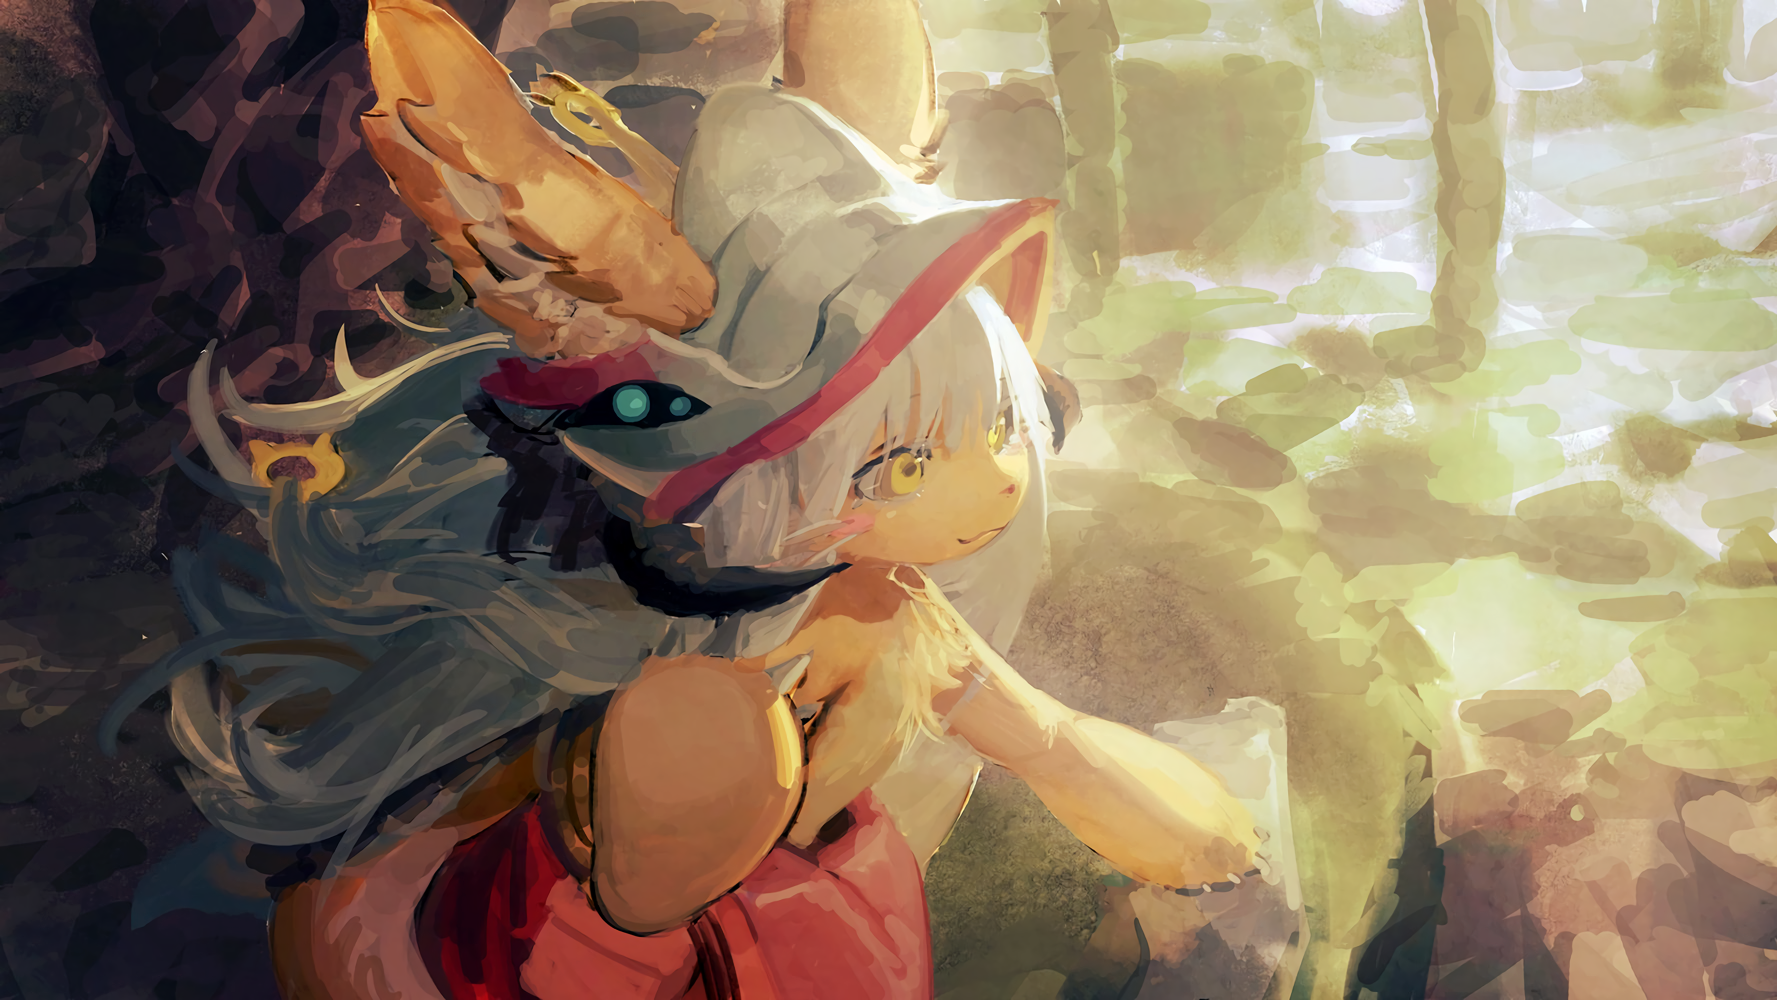

In [34]:
#ナナチはかわいいですね〜
img

In [26]:
dataroot = "test_samples/1514214805.png"
output_dir ="results/"
load_size = 512
gpu_ids = []

In [29]:
if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Anime-to-sketch test options.')
    #parser.add_argument('--dataroot','-i', default='test_samples/', type=str)
    #parser.add_argument('--load_size','-s', default=512, type=int)
    #parser.add_argument('--output_dir','-o', default='results/', type=str)
    #parser.add_argument('--gpu_ids', '-g', default=[], help="gpu ids: e.g. 0 0,1,2 0,2.")
    #opt = parser.parse_args()

    # create model
    model = create_model() # create a model given opt.model and other options
    model.eval()
    # get input data
    if os.path.isdir(dataroot):
        test_list = get_image_list(dataroot)
    elif os.path.isfile(dataroot):
        test_list = [dataroot]
    else:
        raise Exception("{} is not a valid directory or image file.".format(dataroot))
    # save outputs
    save_dir = output_dir
    os.makedirs(save_dir, exist_ok=True)
    
    for test_path in test_list:
        basename = os.path.basename(test_path)
        aus_path = os.path.join(save_dir, basename)
        img,  aus_resize = read_img_path(test_path, load_size)
        aus_tensor = model(img)
        aus_img = tensor_to_img(aus_tensor)
        save_image(aus_img, aus_path, aus_resize)

In [31]:
#output image
from PIL import Image
from io import BytesIO
filename = 'results/1514214805.png'

# 画像ファイルパスから読み込み
img = Image.open(filename)

# numpy配列の取得
img_array = np.asarray(img)

# 色の変換も簡単ですが、できる色が制限されます。
print(img.mode) # RGBA
rgb = img.convert('RGB')

RGB


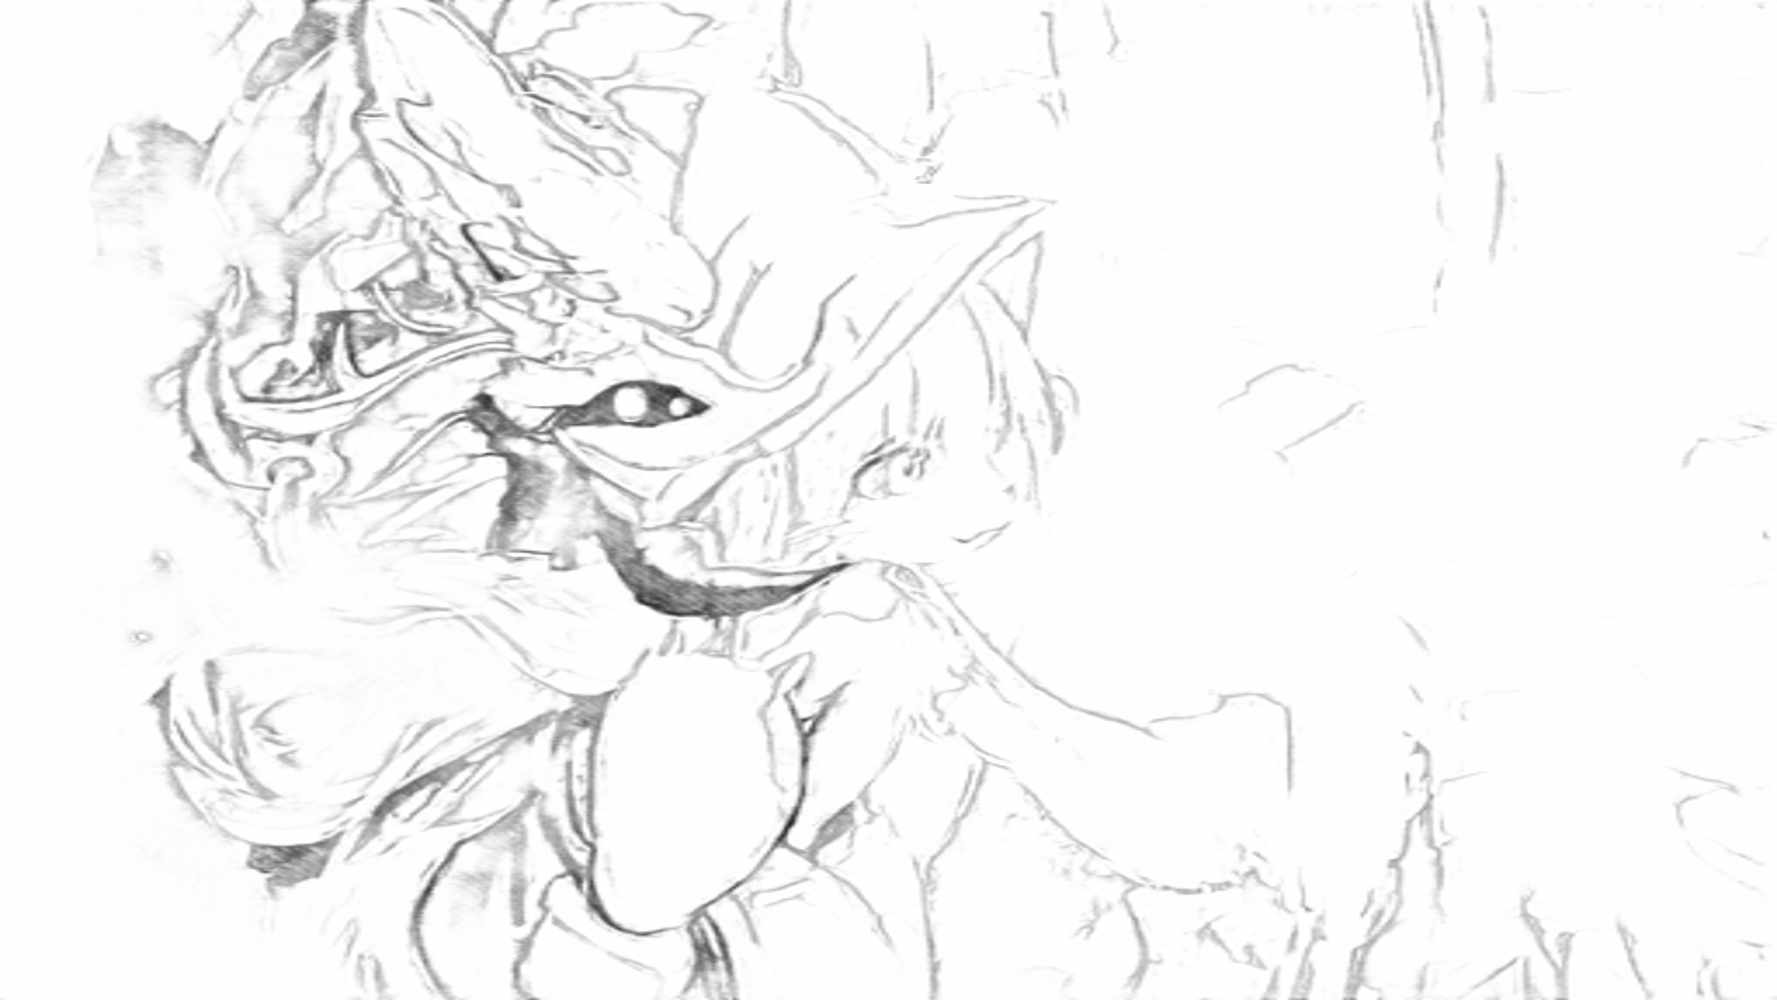

In [32]:
img